In [2]:
from abc import ABC, abstractclassmethod
from typing import Dict, List, Tuple, Optional
from collections.abc import Callable, Iterable
from dataclasses import dataclass, field
from functools import partial


from random import random, shuffle
from glob import glob


import numpy as np
import pandas as pd
import statistics as stats


from plotly.subplots import make_subplots
import plotly.graph_objects as go

from sklearn.linear_model import LinearRegression as golden_standard

# Implementation

In [3]:
def mean_absolute_error(y: np.ndarray, y_pred: np.ndarray) -> np.ndarray:
    """Returns mean absolute error between to vectors"""
    y = y.reshape((y.shape[0], 1))
    y_pred = y_pred.reshape((y_pred.shape[0], 1))
    return np.mean(abs(y_pred - y))

def mean_squared_error(y: np.ndarray, y_pred: np.ndarray) -> np.ndarray:
    """Returns the mean square error between to vectors"""
    y = y.reshape((y.shape[0], 1))
    y_pred = y_pred.reshape((y_pred.shape[0], 1))
    return np.mean((y_pred - y) ** 2)

def root_mean_squared_error(y: np.ndarray, y_pred: np.ndarray) -> np.ndarray:
    y = y.reshape((y.shape[0], 1))
    y_pred = y_pred.reshape((y_pred.shape[0], 1))
    return np.sqrt(np.mean((y_pred - y) ** 2))

def root_mean_squared_log_error(y: np.ndarray, y_pred: np.ndarray) -> np.ndarray:
    """Returns the root mean squared error between to vectors"""
    y = y.reshape((y.shape[0], 1))
    y_pred = y_pred.reshape((y_pred.shape[0], 1))
    return np.sqrt(np.mean((np.log(y_pred+1) - np.log(y+1)) ** 2))

def linear_gradient_descent_step(X: np.ndarray, y: np.ndarray, y_pred: np.ndarray) -> (np.ndarray, np.ndarray):
    """Calculates the adjustment of one step of gradient descent."""
    # batch size
    bs = X.shape[0]
    
    # calculate gradients  
    dT = (2/bs) * ( X.T @ (y_pred - y)) 
    db = (2/bs) * np.sum(y_pred - y) 
    
    return dT, db

def make_polynomial_data(degree, X: np.ndarray) -> np.ndarray:
        """
        Creates the new feature set like a polynomial.
        X -> np.array(X^0, X^1, X^2, ..., X^degree)
        """
        stack = [X, np.ones(X.shape)]
        stack.extend([X**i for i in range(2, degree+1)])
        return np.column_stack(stack)

def make_wave_data(X: np.ndarray) -> np.ndarray:
    """
    Creates the new feature set like a polynomial.
    X -> np.array(X, sin(X), cos(X))
    """
    return np.column_stack([X, np.sin(X), np.cos(X)])
            
def make_exp_data(X: np.ndarray) -> np.ndarray:
    """
    Creates the new feature set like a polynomial.
    X -> np.array(X, sin(X), cos(X))
    """
    return np.column_stack([X, np.exp(X)])

@dataclass
class Model(ABC):
    """Base Representation of a Machine Learning Model."""
    loss: Optional[Callable[[np.ndarray, np.ndarray], np.ndarray]]
    optimizer: Optional[Callable[[np.ndarray, np.ndarray, np.ndarray,], (np.ndarray, float)]]
    hist: Dict[str, List]
    learning_rate: float = 0.1
    epochs: int = 150
    eval_step: int = 10
    early_stop: bool = True
    range_flag: bool = True
    
    @abstractclassmethod
    def predict(self, X: np.ndarray) -> None:
        """Predicts the out come of Matrix X."""
        pass
        
    @abstractclassmethod
    def update_weights(self, X: np.ndarray, y: np.ndarray) -> None:
        """Updates the weights of the model after one step or epoch."""
        pass
    
    @abstractclassmethod
    def fit(self, X: np.ndarray, y: np.ndarray ) -> None:
        """trains the model using the vector features X and labels Y."""
        pass
    
    @abstractclassmethod
    def save_hist(self, X: np.ndarray, y: np.ndarray, i: int) -> None:
        """Saves the parameters of the model in between updates of training."""
        pass
    
    def plot_training(self) -> go.Figure:
        """Animate the change of prediction of the model on training data with dimension of 1."""
        assert self.range_flag == False
        fig=go.Figure().set_subplots(1,1, vertical_spacing=0.05,
                             specs=[[{"type": "scatter", "secondary_y": False}]])
        
        # first frame of the plot
        fig.add_trace(go.Scatter(x=self.hist["x_range"], y=self.hist["y_range"], name="train", mode='markers'), 1,1)
        fig.add_trace(go.Scatter(x=self.hist["x_range"], y=self.hist["y_range"], name="train", mode='markers'), 1,1);

        fig.update(frames=self.hist["frame"])
        
        # details about the plot layout
        sliders_dict = {"active": 0, "yanchor": "top", "xanchor": "left",
                        "currentvalue": { "font": {"size": 20}, "prefix": "Year:", "visible": True, "xanchor": "right"},
                        "transition": {"duration": 300, "easing": "cubic-in-out"}, "pad": {"b": 10, "t": 50}, "len": 0.9, 
                        "x": 0.1, "y": 0, "steps": []}

        updatemenus_dict = {
                "buttons": [{"args": [None, {"frame": {"duration": 500, "redraw": False}, "fromcurrent": True,
                "transition": {"duration": 300, "easing": "quadratic-in-out"}}], "label": "Play", "method": "animate"},
                {"args": [[None], {"frame": {"duration": 0, "redraw": False}, "mode": "immediate", "transition": {"duration": 0}}],
                "label": "Pause", "method": "animate"}], "direction": "left", "pad": {"r": 10, "t": 87}, "showactive": True,
                "type": "buttons", "x": 0.1, "xanchor": "right", "y": 0, "yanchor": "top",
                }

        fig.update_layout(sliders=[sliders_dict],
                          updatemenus = [updatemenus_dict])

        return fig
    
    def plot_history(self, keys: Iterable) -> go.Figure:
        """Plots the keys saved in self.hist for each epoch."""
        fig = make_subplots(specs=[[{"secondary_y": True}]])
        for key in keys:
            fig.add_trace(go.Scatter(x=np.arange(stop=self.epochs,),
                                     y=self.hist[key], name=key))
        return fig

    
class Scaler():
    mean: float
    std: float
    def set_standard_scaler(self, X: np.ndarray) -> np.ndarray:
        """Standardize features by removing the mean and scaling to unit variance and save it for prediction time."""
        self.mean = np.mean(X, axis=0)
        self.std = np.std(X, axis=0)
        standard = (X - self.mean) / self.std

        return standard

    def get_standard_scaler(self, X: np.ndarray) -> np.ndarray:
        """Standardize features by removing the mean of training set and scaling to unit variance of training set."""
        standard = (X - self.mean) / self.std

        return standard    
    

@dataclass
class LinearModel(Model):
    """ This impelimentation on a Linear ML Model, So the model is X_i.T * theta + bias = y_i"""
    # hist argument needs to be a callable otherwise an error will raise
    hist: Dict[str, List] = field(default_factory= lambda: {"theta":[],"bias":[],"loss":[], "frame":[]})
    range_flag: bool = True
    
    def predict( self, X: np.ndarray ):
        """Predicts the out come of Matrix X by calculating X_i.T * theta + bias = y_i"""
        return ( X @ self.theta) + self.bias
    
    def update_weights(self, X: np.ndarray, y: np.ndarray) -> None:
        """Updates the weights of the model after one step or epoch by adjusting theta and bias"""
        y_pred = self.predict(X)
        dT, db = self.optimizer(X, y, y_pred)
        
        self.theta = self.theta - (self.learning_rate * dT)
        self.bias = self.bias - (self.learning_rate * db)
    
    def save_hist(self, X: np.ndarray, y: np.ndarray, i: int) -> None:
        """Saves the informations that are changed in training like loss, bias and theta."""
        y_pred = self.predict(X)
        self.hist["loss"].append(self.loss(y, y_pred))
        self.hist["bias"].append(self.bias)
        self.hist["theta"].append(self.theta)
        
        if X.shape[1] == 1:
            if self.range_flag:
                self.hist["x_range"] = [min(X.reshape(X.shape[0])), max(X.reshape(X.shape[0]))]
                self.hist["y_range"] = [min(y), max(y)]
                self.range_flag = False

            if i % self.eval_step == 0:
                self.hist["frame"].append(go.Frame(data=[go.Scatter(x=X.reshape(X.shape[0]), y=y, name="train", mode='markers'),
                                                    go.Scatter(x=X.reshape(X.shape[0]), y=y_pred, name="predict", mode='markers')]))
        
    def random_initializers(self, dim: int) -> None:
        """Make a random start for theta and bias in X_i.T * theta + bias = y_i."""
        self.bias = random()
        self.theta = np.random.rand(dim)
        
    def shuffle(self, X: np.ndarray, y: np.ndarray) -> (np.ndarray, np.ndarray):
        """Shuffles the data randomly."""
        iter_index = list(range(X.shape[0]))
        shuffle(iter_index)
        iter_X = X[iter_index].copy()
        iter_y = y[iter_index].copy()
        
        return iter_X, iter_y
        
    def fit(self, X: np.ndarray, y: np.ndarray) -> None:
        """Train data by updating theta and bias"""
        # create a random start with the shape of your features
        self.random_initializers(X.shape[1])
        self.save_hist(X, y, 0)
          
        # gradient descent learning
        for i in range(1, self.epochs+1) :
            
            # iter_X, iter_y = self.shuffle(X, y)
            iter_X, iter_y = X, y
            
            self.update_weights(iter_X, iter_y)
            self.save_hist(iter_X, iter_y, i)
            if self.hist["loss"][-1] > self.hist["loss"][-2] and self.early_stop:
                break

@dataclass
class LinearRegression(LinearModel):
    """Linear Model with gradient descent as the learner and mse as the loss function."""
    loss: Callable[[np.ndarray, np.ndarray], np.ndarray]= mean_squared_error
    optimizer: Callable[[np.ndarray, np.ndarray, np.ndarray,], (np.ndarray, float)]= linear_gradient_descent_step
    basis_function: Callable[np.ndarray, np.ndarray] = lambda x:x
    training: bool = True
    
    def fit(self, X: np.ndarray, y: np.ndarray) -> None:
        """Train data by updating theta and bias with a modification for prediction later."""
        self.training = True
        super().fit(self.basis_function(X), y)
        self.training = False
    
    def save_hist(self, X: np.ndarray, y: np.ndarray, i: int) -> None:
        """Saves the informations that are changed in training like loss, bias and theta, modified for this class to plot_training."""
        super().save_hist(X, y, i)
        
        if self.range_flag:
                self.hist["x_range"] = [min(X[:,1].reshape(X.shape[0])), max(X[:,0].reshape(X.shape[0]))]
                self.hist["y_range"] = [min(y), max(y)]
                self.range_flag = False
                
        y_pred = self.predict(X)
        if i % self.eval_step == 0:
            self.hist["frame"].append(go.Frame(data=[go.Scatter(x=X[:,0].reshape(X.shape[0]), y=y, name="train", mode='markers'),
                                                go.Scatter(x=X[:,0].reshape(X.shape[0]), y=y_pred, name="predict", mode='markers')]))
            
    def predict( self, X: np.ndarray ) -> np.ndarray:
        """Predicts the out come of vector X."""
        if self.training == True:
            return super().predict(X)
        else:
            return super().predict(self.basis_function(X))

@dataclass
class LWLinearRegression():
    X: np.ndarray
    y: np.ndarray
    tau: float = 1.0

    # overwrite training with closed formula
    def fit(self, x0: np.ndarray) -> None:
        """Train data by updating theta and bias"""
        m = self.X.shape[0]
        y_train = self.y.reshape(m,1)
        w = np.mat(np.eye(m))


        for i in range(m):
            diff = x0 - self.X[i]
            w[i,i] = np.exp(np.linalg.norm(diff)**2 / (-2.0*self.tau**2))
        
        # print(f"self.X.T={self.X.T.shape}")
        # print(f"w*self.X={(w*self.X).shape}")
        # print(f" (self.X.T * (w*self.X)).I = { (self.X.T * (w*self.X)).I.shape}")
        # print(f"(self.X.T*w){(self.X.T*w).shape}")
        # print(f"self.y={y_train}")
        
        theta = (self.X.T * (w*self.X)).I * ((self.X.T*w)*y_train)
        
        return theta
    
    # overwirte predict
    def predict( self, X: np.ndarray ) -> np.ndarray:
        m = X.shape[0]
        ypred = np.zeros((m,1))
        for i, xi in enumerate(X):
            ypred[i] = xi * self.fit(xi)
        
        return ypred
    
def load_npy(path: str) -> Dict[str, np.ndarray]:
    """Loads every npy file in the path."""
    dataloader = {file_path.split("/")[-1].split(".")[0]: np.load(file_path) for file_path in glob(path+"*.npy")}
    return dataloader


def plot(plot_points: Iterable[Tuple[np.ndarray, np.ndarray, str]]) -> go.Figure:
    """Ploting all the (X, y, plot_name) on the same figure."""
    fig = make_subplots(specs=[[{"secondary_y": False}]])
    for X, y, name in plot_points:
        fig.add_trace(go.Scatter(x=X, y=y, name=name, mode='markers'))
    return fig  
    
def train(dataloader: Dict[str, np.ndarray], model_type: Model, scale=True,*args, test: bool=True, plot_flag= True,**kargs) -> Model:
    """trains and evaluates model_type on data in dataloader"""
    print("Creating Model ...")
    model = model_type(*args, **kargs)
    
    print("Training Model ...")
    scaler = Scaler()
    X_train = scaler.set_standard_scaler(dataloader["x_train"]) if scale else dataloader["x_train"]
    model.fit(X_train, dataloader["y_train"])
    
    print("*** Training error ***")
    print(model.hist["loss"][-1])
    
    if plot_flag == True:
        if model.range_flag == False:
            print("*** Visualization of Training ***")
            model.plot_training().show()

        print("*** Model Performance Plot ***")
        model.plot_history(keys=["loss"]).show()
    
    if test:
        print("*** Test Performance ***")
        X_test = scaler.get_standard_scaler(dataloader["x_test"]) if scale else dataloader["x_test"]
        y_pred = model.predict(X_test)
        plot([(dataloader["x_test"].reshape(dataloader["x_test"].shape[0]), dataloader["y_test"].reshape(dataloader["y_test"].shape[0]), "test"), 
          (dataloader["x_test"].reshape(dataloader["x_test"].shape[0]), y_pred, "prediction")]).show()

        print("*** Test error ***")
        print(kargs["loss"](dataloader["y_test"], y_pred))
    
    return model
    


# Question 1
1. Is the relationship linear? 

    By ploting the data we can see that the data seems to be non-linear but is it really non-linear? if we trust that the data gathering wasn't bias and done randomly, it seems so.

2. Do you need feature engineering to add any non-linearity?
    i. If so, how can you engineer these features?
       by using f(x) instead of x
    ii. What are some functions that you can try?
       cosine, sine, polynomial, exp, ...
        1. Plot each of them individually to verify!

    you can use sine or cosine to engineer features, since the data looks like a wave and waves are made by sine and cosine. which I didn't because sine and cosine could be replicated with ploynomials but the way the question is ask seems to hint that we should try a couple of functions so I will add the result below.
    
Firstly, I made a linear model and check if it worked. Since I didn't get a good fit with linear regression, I had to engineer features So I made a ploynomial regression model, things got better but the fit wasn't that good and with some learning rates the models diverged. So, I standardized the data and try again. This time they would converge with a higher learning rates and the issue was fixed. I tried the ploynomial model for 5000 epochs till the error became less than one and I stop, I trained it for more epochs and the loss still came down and the model did better on the test set.
    

Creating Model ...
Training Model ...
*** Training error ***
13.012867723809997
*** Visualization of Training ***


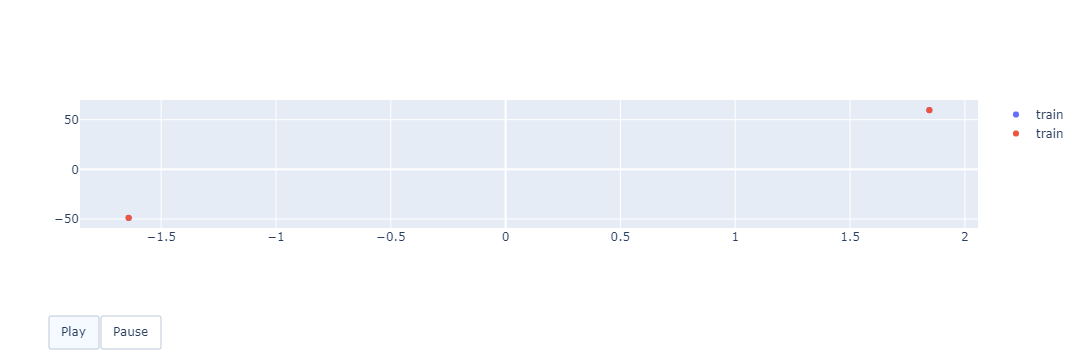

*** Model Performance Plot ***


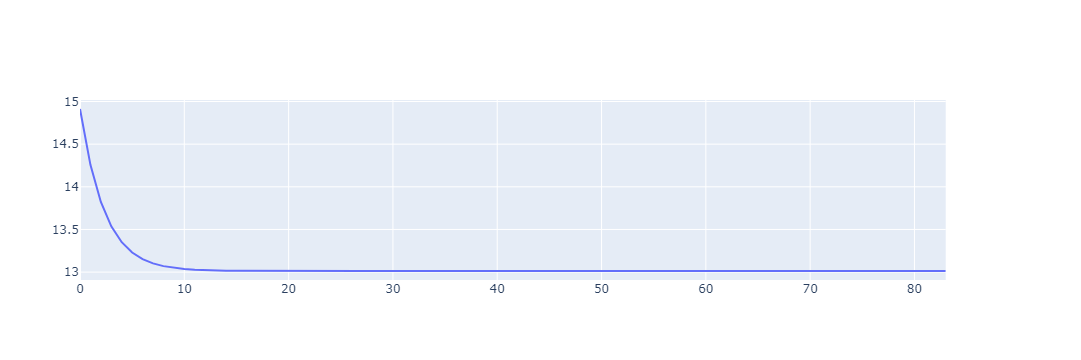

*** Test Performance ***


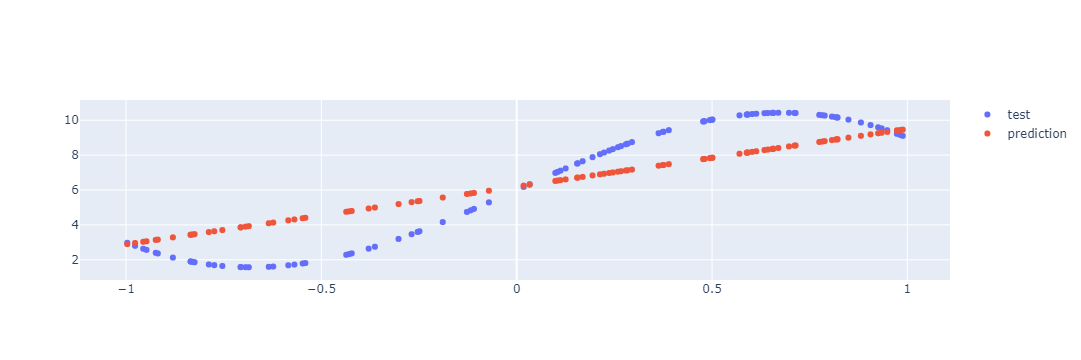

*** Test error ***
1.6792398882170099


In [66]:
# **** If the animations seems vague click on the house(reset axes) ****
dataloader = load_npy("./") 
model = train(dataloader, LinearRegression, learning_rate=0.1, epochs=100, optimizer=linear_gradient_descent_step,
      loss=root_mean_squared_error, eval_step=10, early_stop=True)

*** Test Performance ***


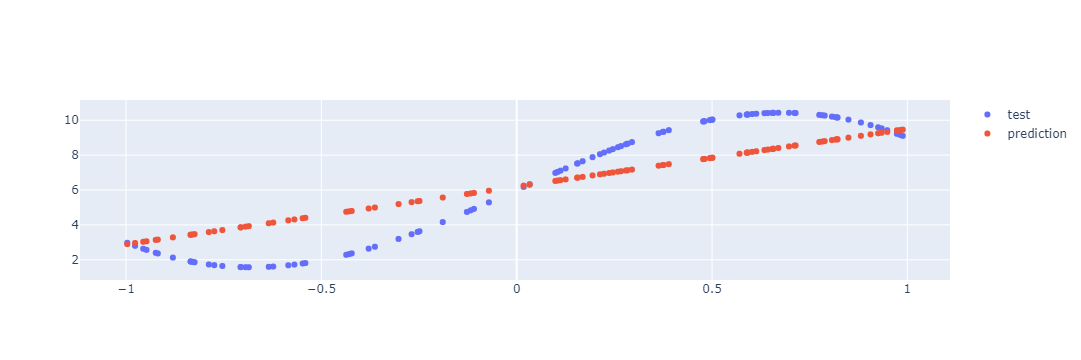

*** Test error ***
1.6792398690412793


In [67]:
reg = golden_standard().fit(dataloader["x_train"], dataloader["y_train"])
print("*** Test Performance ***")
y_pred = reg.predict(dataloader["x_test"])
plot([(dataloader["x_test"].reshape(dataloader["x_test"].shape[0]), dataloader["y_test"].reshape(dataloader["y_test"].shape[0]), "test"), 
      (dataloader["x_test"].reshape(dataloader["x_test"].shape[0]), y_pred, "prediction")]).show()
print("*** Test error ***")
print(root_mean_squared_error(dataloader["y_test"], y_pred))

Test the regression on X^2

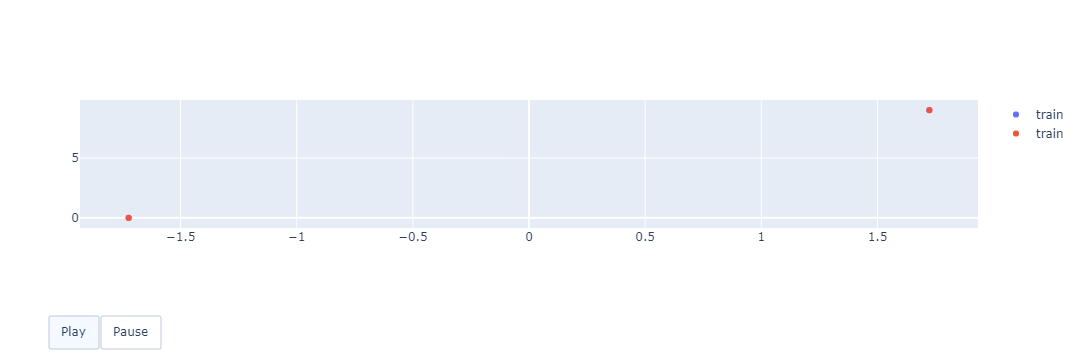

In [68]:
# **** If the animations seems vague click on the house(reset axes) ****
X = np.linspace(-3, 3, 200)
y = X**2

model = LinearRegression(learning_rate=0.2, epochs=15, optimizer= linear_gradient_descent_step, loss=mean_squared_error, eval_step=1, early_stop= True)
scaler = Scaler()
X_train = scaler.set_standard_scaler(X)

model.fit(X_train.reshape(200,1), y)
model.plot_training()

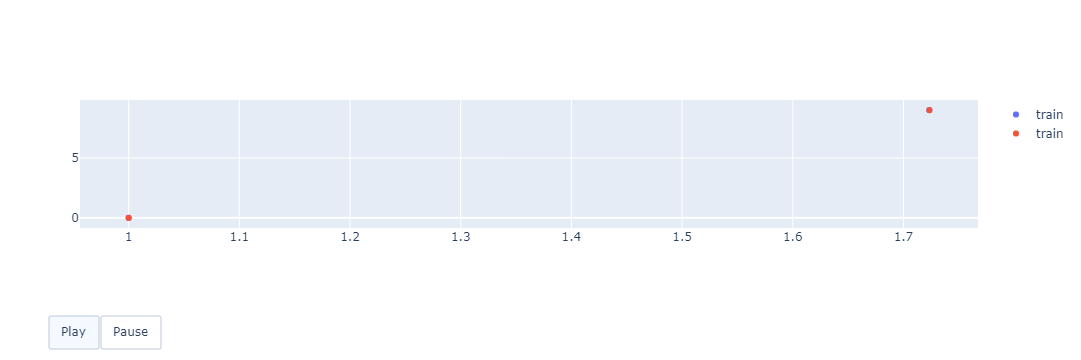

In [71]:
# **** If the animations seems vague click on the house(reset axes) ****
X = np.linspace(-3, 3, 200)
y = X**2

model = LinearRegression(learning_rate=0.01, epochs=500, optimizer= linear_gradient_descent_step, loss=mean_squared_error,
                             eval_step=100, early_stop= True, basis_function=lambda X: make_polynomial_data(5,X))

scaler = Scaler()
X_train = scaler.set_standard_scaler(X)

model.fit(X_train.reshape(200,1), y)
model.plot_training()


Using Basis Functions

Creating Model ...
Training Model ...
*** Training error ***
0.13770370259158232
*** Visualization of Training ***


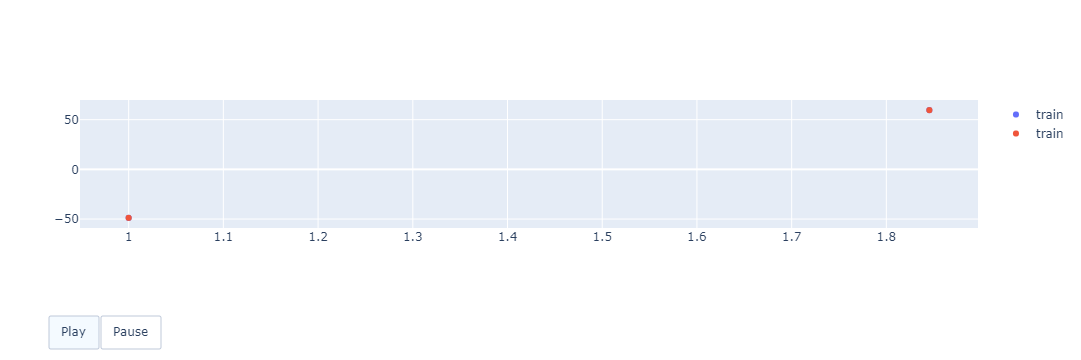

*** Model Performance Plot ***


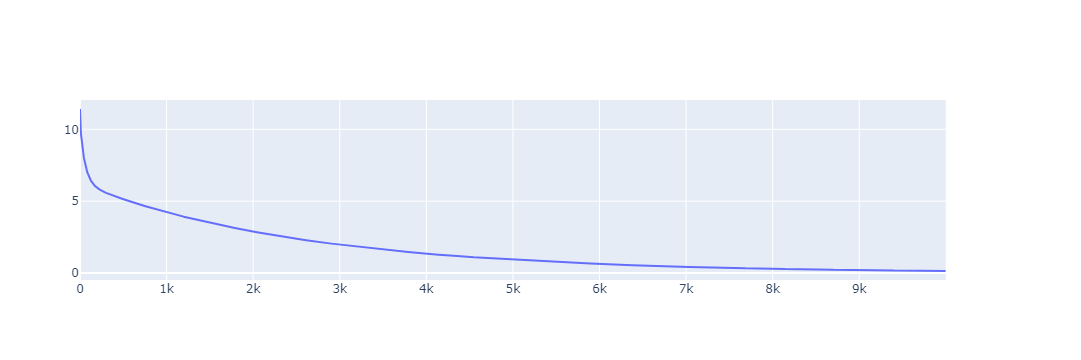

*** Test Performance ***


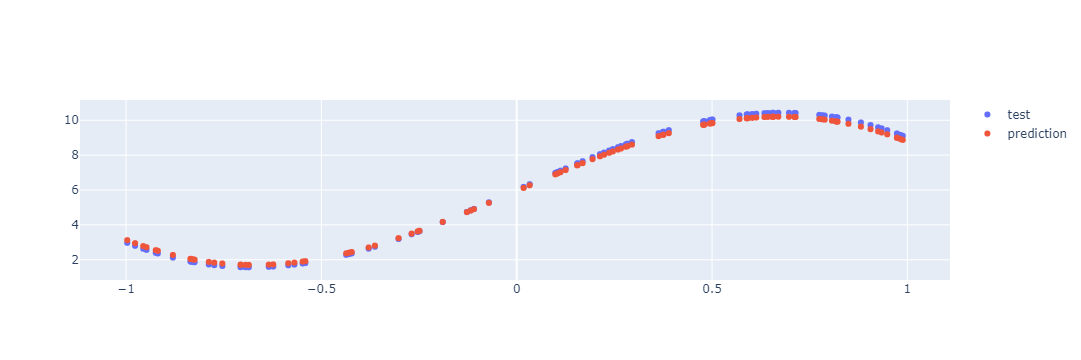

*** Test error ***
0.16744885481339716


In [115]:
# **** If the animations seems vague click on the house(reset axes) ****
model = train(load_npy("./"), LinearRegression, basis_function=lambda X: make_polynomial_data(5,X), learning_rate=0.01, epochs=10000, optimizer=linear_gradient_descent_step,
      loss=root_mean_squared_error, eval_step=1000, early_stop=True)

Still with the plots showing that I'm getting a better fit on both test and train data my loss is more than the simple regression

Creating Model ...
Training Model ...
*** Training error ***
9.342686042900771
*** Visualization of Training ***


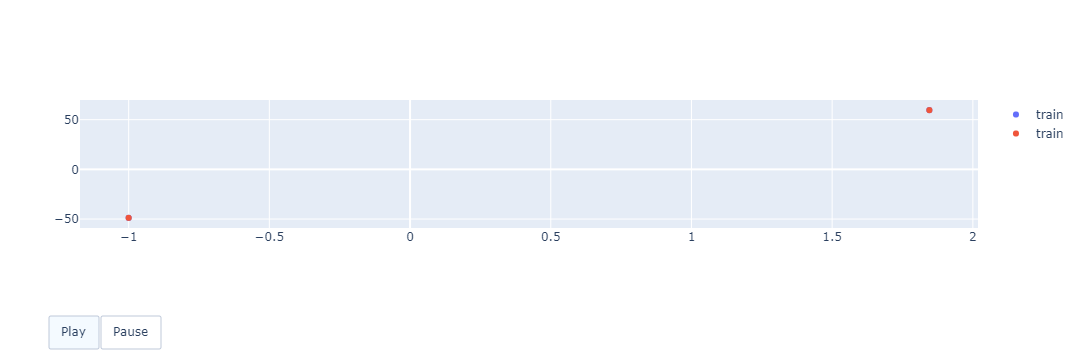

*** Model Performance Plot ***


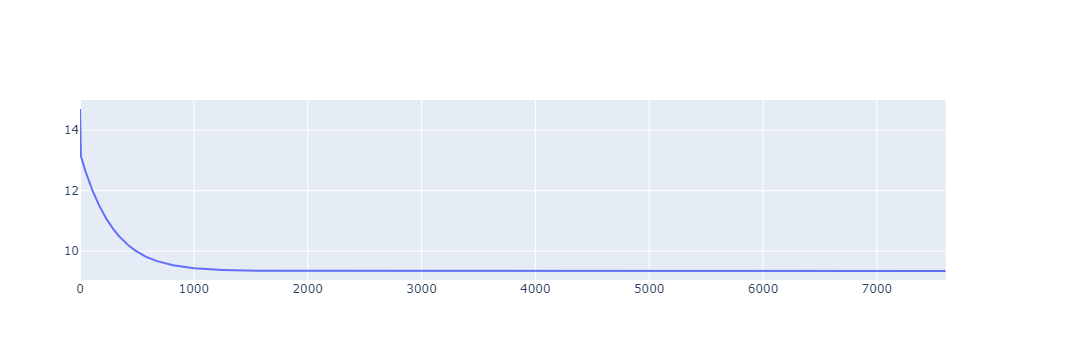

*** Test Performance ***


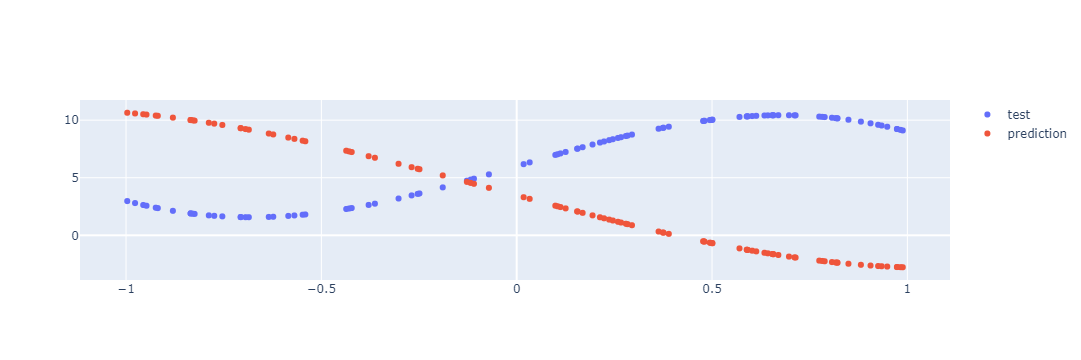

*** Test error ***
8.984242402131327


In [76]:
# **** If the animations seems vague click on the house(reset axes) ****
model = train(load_npy("./"), LinearRegression, basis_function=make_wave_data, scale=True, learning_rate=0.1, epochs=100000, optimizer=linear_gradient_descent_step,
      loss=root_mean_squared_error, eval_step=1000, early_stop=True, )

# Question 2
1. What is the average least squares error for the given data using your simple linear regression model?
2. Which factor has the most effect on the final value? How do you know this? Can you use only this feature to predict the price?
3. Which factor has the least effect on the final value? How do you know this? What effect does removing this feature have on the performance?

In [77]:
df = pd.read_csv("Assignment1_Q2_Data.csv", index_col=0)
df

Local Price  Bathrooms  Land Area  Living area  # Garages  # Rooms  \
House ID                                                                       
1              4.9176        1.0     3.4720        0.998        1.0        7   
2              5.0208        1.0     3.5310        1.500        2.0        7   
3              4.5429        1.0     2.2750        1.175        1.0        6   
4              4.5573        1.0     4.0500        1.232        1.0        6   
5              5.0597        1.0     4.4550        1.121        1.0        6   
6              3.8910        1.0     4.4550        0.988        1.0        6   
7              5.8980        1.0     5.8500        1.240        1.0        7   
8              5.6039        1.0     9.5200        1.501        0.0        6   
9             16.4202        2.5     9.8000        3.420        2.0       10   
10            14.4598        2.5    12.8000        3.000        2.0        9   
11             5.8282        1.0     6.4350        1.225        2.0        6   
12             5.3003        1.0     4.9883        1.552        1.0        6   
13             6.2712        1.0     5.5200        0.975        1.0        5   
14             5.9592        1.0     6.6660        1.121        2.0        6   
15             5.0500        1.0     5.0000        1.020        0.0        5   
16             5.6039        1.0     9.5200        1.501        0.0        6   
17             8.2464        1.5     5.1500        1.664        2.0        8   
18             6.6969        1.5     6.9020        1.488        1.5        7   
19             7.7841        1.5     7.1020        1.376        1.0        6   
20             9.0384        1.0     7.8000        1.500        1.5        7   
21             5.9894        1.0     5.5200        1.256        2.0        6   
22             7.5422        1.5     4.0000        1.690        1.0        6   
23             8.7951        1.5     9.8900        1.820        2.0        8   
24             6.0931        1.5     6.7265        1.652        1.0        6   
25             8.3607        1.5     9.1500        1.777        2.0        8   
26             8.1400        1.0     8.0000        1.504        2.0        7   
27             9.1416        1.5     7.3262        1.831        1.5        8   
28            12.0000        1.5     5.0000        1.200        2.0        6   

          # Bedrooms  Age of home  Construction type  Architecture type  \
House ID                                                                  
1                  4           42                  3                  1   
2                  4           62                  1                  1   
3                  3           40                  2                  1   
4                  3           54                  4                  1   
5                  3           42                  3                  1   
6                  3           56                  2                  1   
7                  3           51                  2                  1   
8                  3           32                  1                  1   
9                  5           42                  2                  1   
10                 5           14                  4                  1   
11                 3           32                  1                  1   
12                 3           30                  1                  2   
13                 2           30                  1                  2   
14                 3           32                  2                  1   
15                 2           46                  4                  1   
16                 3           32                  1                  1   
17                 4           50                  4                  1   
18                 3           22                  1                  1   
19                 3           17                  2                  1   
20                 3           23 

1. What is the average least squares error for the given data using your simple linear regression model? 9.31

Creating Model ...
Training Model ...
*** Training error ***
9.639292266312376
*** Visualization of Training ***


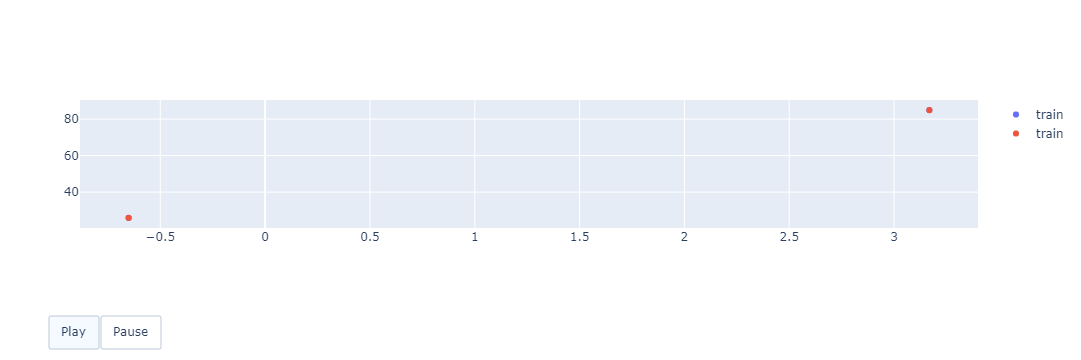

*** Model Performance Plot ***


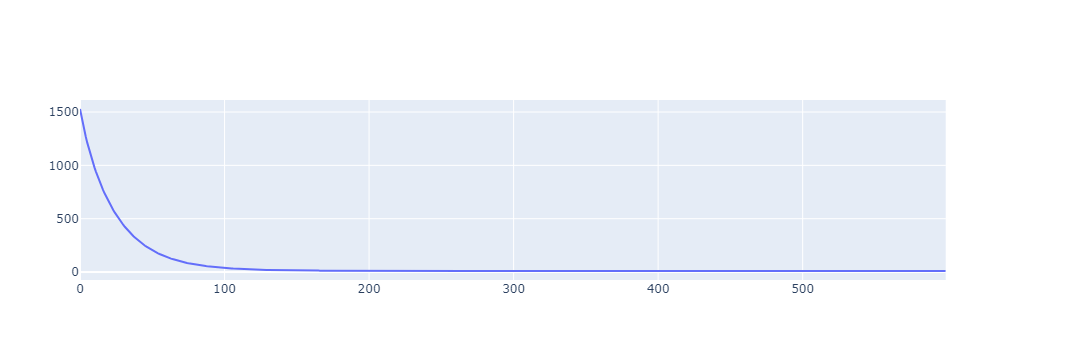

In [86]:
dataloader = { "x_train": np.array(df[df.columns[:-1]]), "y_train": np.array(df[df.columns[-1]])}
model = train(dataloader=dataloader, model_type=LinearRegression, learning_rate=0.01,
              epochs=600, optimizer= linear_gradient_descent_step,
              loss=mean_squared_error, eval_step=60, early_stop= True, scale=True,
              test= False,
             )

In [87]:
dataloader = { "x_train": np.array(df[df.columns[:-1]]), "y_train": np.array(df[df.columns[-1]])}
reg = golden_standard().fit(dataloader["x_train"], dataloader["y_train"])
y_pred = reg.predict(dataloader["x_train"])
print("*** Training error ***")
print(root_mean_squared_error(dataloader["y_train"], y_pred))

*** Training error ***
3.0523451969949487


2. Which factor has the most effect on the final value? How do you know this? Can you use only this feature to predict the price?

In [143]:
df.corr()

Local Price  Bathrooms  Land Area  Living area  # Garages  \
Local Price           1.000000   0.881496   0.628046     0.840312   0.513695   
Bathrooms             0.881496   1.000000   0.583495     0.894029   0.399777   
Land Area             0.628046   0.583495   1.000000     0.680651   0.175567   
Living area           0.840312   0.894029   0.680651     1.000000   0.363548   
# Garages             0.513695   0.399777   0.175567     0.363548   1.000000   
# Rooms               0.750969   0.757478   0.564698     0.840513   0.566325   
# Bedrooms            0.652932   0.726375   0.459350     0.791281   0.539703   
Age of home          -0.342791  -0.200938  -0.382963    -0.177487  -0.057658   
Construction type     0.145689   0.187706  -0.108468     0.055476   0.028662   
Architecture type     0.057270  -0.250035   0.089554    -0.063674   0.096213   
# Fire places         0.491864   0.481197   0.376435     0.371852   0.291581   
Price (1000$)         0.923147   0.925081   0.666577     0.921651   0.461696   

                    # Rooms  # Bedrooms  Age of home  Construction type  \
Local Price        0.750969    0.652932    -0.342791           0.145689   
Bathrooms          0.757478    0.726375    -0.200938           0.187706   
Land Area          0.564698    0.459350    -0.382963          -0.108468   
Living area        0.840513    0.791281    -0.177487           0.055476   
# Garages          0.566325    0.539703    -0.057658           0.028662   
# Rooms            1.000000    0.924445     0.011342           0.084212   
# Bedrooms         0.924445    1.000000     0.106928           0.126131   
Age of home        0.011342    0.106928     1.000000           0.168621   
Construction type  0.084212    0.126131     0.168621           1.000000   
Architecture type -0.060402   -0.248286    -0.499828          -0.184604   
# Fire places      0.396835    0.265366     0.090787           0.110257   
Price (1000$)      0.777145    0.700556    -0.299297           0.172716   

                   Architecture type  # Fire places  Price (1000$)  
Local Price                 0.057270       0.491864       0.923147  
Bathrooms                  -0.250035       0.481197       0.925081  
Land Area                   0.089554       0.376435       0.666577  
Living area                -0.063674       0.371852       0.921651  
# Garages                   0.096213       0.291581       0.461696  
# Rooms                    -0.060402       0.396835       0.777145  
# Bedrooms                 -0.248286       0.265366       0.700556  
Age of home                -0.499828       0.090787      -0.299297  
Construction type          -0.184604       0.110257       0.172716  
Architecture type           1.000000      -0.264363      -0.022302  
# Fire places              -0.264363       1.000000       0.490053  
Price (1000$)              -0.022302       0.490053       1.000000

In [102]:
column_names = list(df.columns)
column_names.remove("Price (1000$)")
corr = [(feature, df["Price (1000$)"].corr(df[feature])) for feature in column_names]
corr = sorted(corr, key = lambda x: x[1], reverse=True)
corr

[('Bathrooms', 0.9250812627522111),
 ('Local Price', 0.9231467705894107),
 ('Living area', 0.9216509137333995),
 ('# Rooms', 0.7771447299895513),
 ('# Bedrooms', 0.7005561967836851),
 ('Land Area', 0.6665769683197594),
 ('# Fire places', 0.49005259427831155),
 ('# Garages', 0.46169563321654716),
 ('Construction type', 0.17271571228182958),
 ('Architecture type', -0.02230177481496273),
 ('Age of home', -0.2992973332573461)]

By correlation it seems to be Bathrooms > Local Price > Living area

In [107]:
loss_with_one = [(feature ,train(dataloader={ "x_train": np.array(df[feature]).reshape(28,1), "y_train": np.array(df[df.columns[-1]])},
              model_type=LinearRegression, learning_rate=0.01,
              epochs=600, optimizer= linear_gradient_descent_step, plot_flag= False,
              loss=mean_squared_error, eval_step=60, early_stop= True, scale=True,
              test= False).hist["loss"][-1])  for feature in column_names]

Creating Model ...
Training Model ...
*** Training error ***
28.563353155142313
Creating Model ...
Training Model ...
*** Training error ***
27.872386379864615
Creating Model ...
Training Model ...
*** Training error ***
107.3879641759177
Creating Model ...
Training Model ...
*** Training error ***
29.096655406907466
Creating Model ...
Training Model ...
*** Training error ***
152.0615768937958
Creating Model ...
Training Model ...
*** Training error ***
76.53857006035751
Creating Model ...
Training Model ...
*** Training error ***
98.41039066970333
Creating Model ...
Training Model ...
*** Training error ***
175.94501024250616
Creating Model ...
Training Model ...
*** Training error ***
187.49174772368445
Creating Model ...
Training Model ...
*** Training error ***
193.16061479682648
Creating Model ...
Training Model ...
*** Training error ***
146.84583128698765


In [108]:
loss_with_one = sorted(loss_with_one, key = lambda x: x[1], reverse=False)
loss_with_one

[('Bathrooms', 27.872386379864615),
 ('Local Price', 28.563353155142313),
 ('Living area', 29.096655406907466),
 ('# Rooms', 76.53857006035751),
 ('# Bedrooms', 98.41039066970333),
 ('Land Area', 107.3879641759177),
 ('# Fire places', 146.84583128698765),
 ('# Garages', 152.0615768937958),
 ('Age of home', 175.94501024250616),
 ('Construction type', 187.49174772368445),
 ('Architecture type', 193.16061479682648)]

By training only on it seems to be Bathrooms > Local Price > Living area

In [145]:
leave_them_out = [(feature ,train(dataloader={ "x_train": np.array(df[[column for column in column_names if column != feature]]).reshape(28,10),
                                              "y_train": np.array(df[df.columns[-1]])},
              model_type=LinearRegression, learning_rate=0.01,
              epochs=600, optimizer= linear_gradient_descent_step, plot_flag= False,
              loss=mean_squared_error, eval_step=60, early_stop= True, scale=True,
              test= False).hist["loss"][-1])  for feature in column_names]

Creating Model ...
Training Model ...
*** Training error ***
10.121569924681037
Creating Model ...
Training Model ...
*** Training error ***
10.605106293870067
Creating Model ...
Training Model ...
*** Training error ***
9.6791962652751
Creating Model ...
Training Model ...
*** Training error ***
13.895633922272017
Creating Model ...
Training Model ...
*** Training error ***
10.221615176134735
Creating Model ...
Training Model ...
*** Training error ***
9.724050417761164
Creating Model ...
Training Model ...
*** Training error ***
9.640884957196727
Creating Model ...
Training Model ...
*** Training error ***
9.94777569532892
Creating Model ...
Training Model ...
*** Training error ***
10.71984776853393
Creating Model ...
Training Model ...
*** Training error ***
9.841688801613472
Creating Model ...
Training Model ...
*** Training error ***
10.284769638480492


In [146]:
leave_them_out = sorted(leave_them_out, key = lambda x: x[1], reverse=True)
leave_them_out

[('Living area', 13.895633922272017),
 ('Construction type', 10.71984776853393),
 ('Bathrooms', 10.605106293870067),
 ('# Fire places', 10.284769638480492),
 ('# Garages', 10.221615176134735),
 ('Local Price', 10.121569924681037),
 ('Age of home', 9.94777569532892),
 ('Architecture type', 9.841688801613472),
 ('# Rooms', 9.724050417761164),
 ('Land Area', 9.6791962652751),
 ('# Bedrooms', 9.640884957196727)]

By using all the other features it seems to be Living area > Construction type > Bathrooms
The above shows that 3 features are the most important: Bathrooms, Living area, Local Price and I believe that the most important feature is Living area since it had the biggest gap difference between the three experiments.

Creating Model ...
Training Model ...
*** Training error ***
20.35955294547602
*** Visualization of Training ***


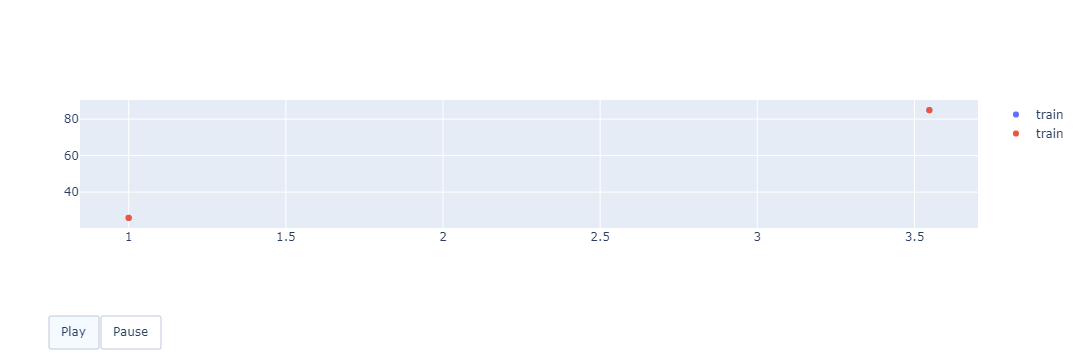

*** Model Performance Plot ***


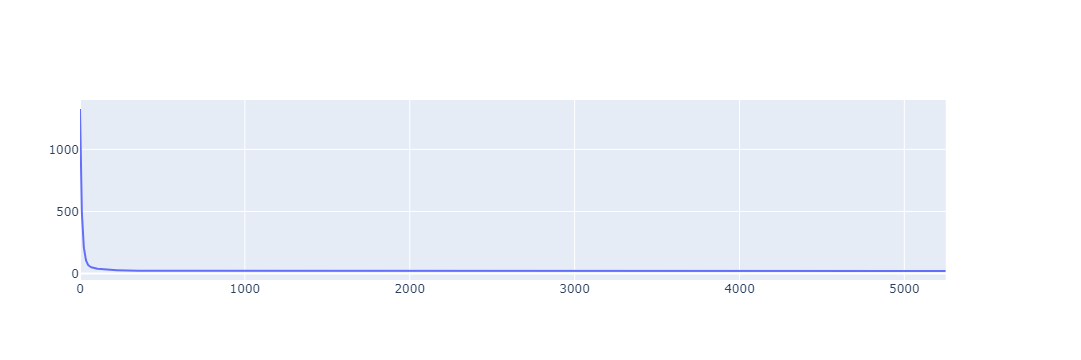

In [131]:
model = train(dataloader={ "x_train": np.array(df["Living area"]).reshape(28,1), "y_train": np.array(df[df.columns[-1]])},
              model_type=LinearRegression, learning_rate=0.01, basis_function=lambda x: make_polynomial_data(3,x),
              epochs=10000, optimizer= linear_gradient_descent_step, plot_flag= True,
              loss=mean_squared_error, eval_step=100, early_stop= True, scale=True, test= False)

it's good but not better than not using other features

Creating Model ...
Training Model ...
*** Training error ***
13.450662119737393
*** Visualization of Training ***


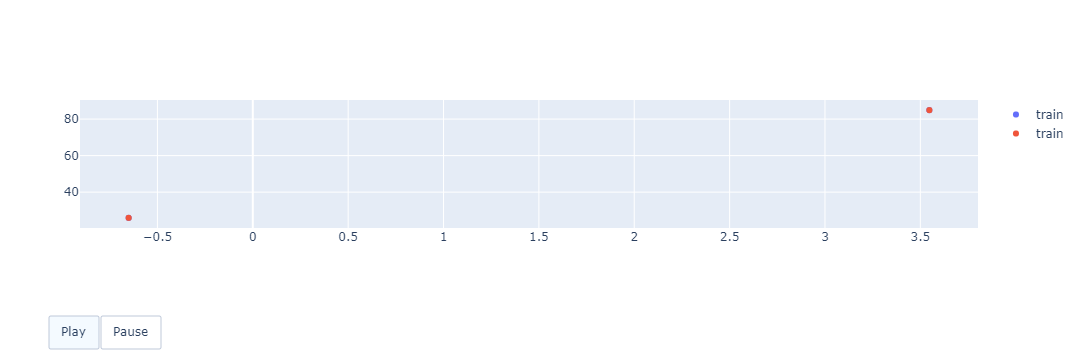

*** Model Performance Plot ***


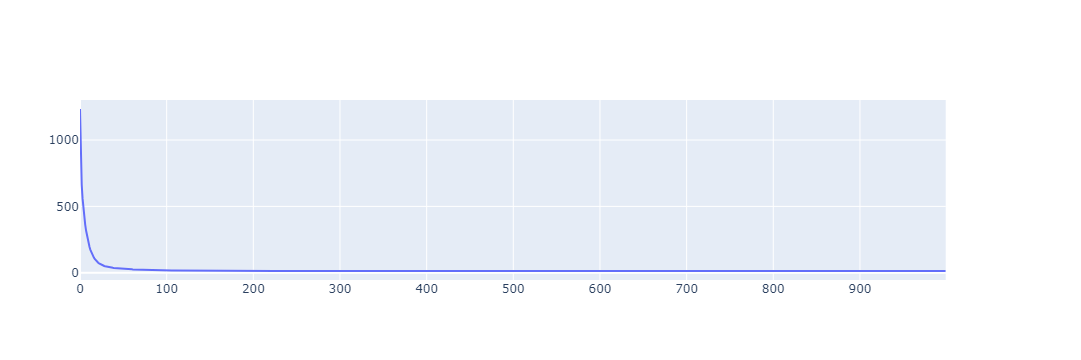

In [142]:
model = train(dataloader={ "x_train": np.array(df[["Living area",  "Bathrooms", "Living area",]]).reshape(28,3), "y_train": np.array(df[df.columns[-1]])},
              model_type=LinearRegression, learning_rate=0.01, basis_function=lambda x: make_polynomial_data(2,x),
              epochs=1000, optimizer= linear_gradient_descent_step, plot_flag= True,
              loss=mean_squared_error, eval_step=100, early_stop= True, scale=True, test= False)

3. Which factor has the least effect on the final value? How do you know this? What effect does removing this feature have on the performance?
As we explored above Architecture type was the worst feature, and leaving it out will get us an accuracy of 9.783092994843207

# Question 3

1. Do you need any basis functions when using the locally weighted approach?
    We will get a better result with a basis function (comment X_train = make_polynomial_data(5, X_train) (line 8))
2. What is the difference between this implementation and the one for Question 1?
    It's instant train model (the training has a close formula), and for each prediction we will retrain the model

Creating Model ...
*** Test Performance ***


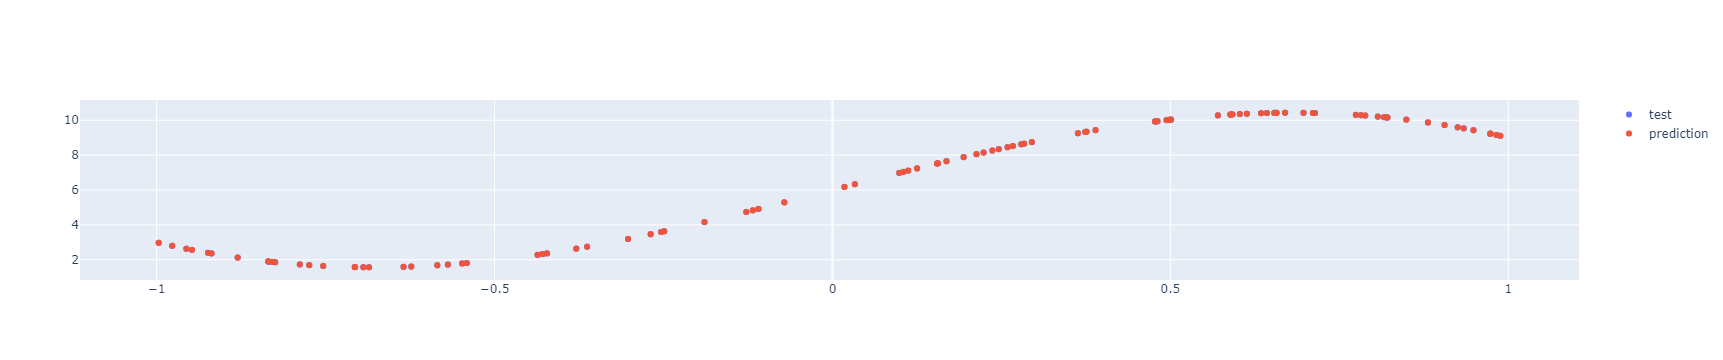

*** Test error ***
9.471611300336464e-28


In [6]:
# **** If the animations seems vague click on the house(reset axes) ****
"""trains and evaluates model_type on data in dataloader"""
print("Creating Model ...")
scale = True
dataloader = load_npy("./")
sacler = Scaler()
X_train = dataloader["x_train"]
X_train = sacler.set_standard_scaler(X_train) if scale else X_train
X_train = make_polynomial_data(5, X_train)


model = LWLinearRegression(X=X_train, y=dataloader["y_train"], tau=1,)

print("*** Test Performance ***")
X_test = dataloader["x_test"]
X_test = sacler.get_standard_scaler(X_test) if scale else dataloader["x_test"]
X_test = make_polynomial_data(5, X_test)

y_pred = model.predict(X_test)

m = dataloader["x_test"].shape[0]
plot([(dataloader["x_test"].reshape(m), dataloader["y_test"].reshape(m), "test"), 
  (dataloader["x_test"].reshape(m), y_pred.reshape(m), "prediction")]).show()

print("*** Test error ***")
print(mean_squared_error(dataloader["y_test"], y_pred))